In [1]:
%run config_check.py

You are currently using this configuration -
Python:  3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]
Numpy:  1.14.0
Scipy:  1.0.0
Matplotlib:  2.1.2
Pystan:  2.17.1.0

The code was tested on Python:  3.6.2 |Anaconda, Inc.| (default, Sep 30 2017, 18:42:57) [GCC 7.2.0], Numpy:  1.13.1, Scipy:  0.19.1, Matplotlib:  2.0.2, Pystan:  2.17.1.0


In [2]:
# <api>
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from matplotlib import pyplot as plt
%matplotlib inline

# Load classes and functions from the previous parts
from jupyter_cms.loader import load_notebook
smpl1 = load_notebook('./Sampling_part1.ipynb')
smpl2 = load_notebook('./Sampling_part2.ipynb')
smpl3 = load_notebook('./Sampling_part3.ipynb')
smpl4 = load_notebook('./Sampling_part4.ipynb')
smpl5 = load_notebook('./Sampling_part5.ipynb')

# Sampling methods

## PyStan

*Stan* is a probabilistic programming language which uses automatic differentiation and Hamiltonian MC under the hood. Its default sampler is called **NUTS** (No U-Turn Sampler) which has no free parameters. It is based on the idea that a good proposal should efficiently explore the distribution and thus, move as far away from the starting point as possible. NUTS integrates the Hamiltonian until the direction of motion starts to point back to the starting point, i.e. it would make a U-turn.

Note: The actual algorithm is more complicated as it needs to ensure that the proposal is reversible and obeys detailed balance.

Below is the linear regression model in PyStan $\ldots$ it would be very similar when using RStan

In [3]:
import pystan

# 2-dimensional Gaussian example
model_code = """
    data {
    }
    transformed data {
        matrix[2,2] Sigma;
        vector[2] mu;
        
        mu[1] <- 0; mu[2] <- 0;
        Sigma[1,1] <- 1; Sigma[1,2] <- 0.99; Sigma[2,1] <- 0.99; Sigma[2,2] <- 1;
    }
    parameters {
        vector[2] x;
    }
    model {
        x ~ multi_normal(mu, Sigma);
    }
"""

samples = pystan.stan(model_code=model_code, iter=42, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9edd5d1d78df2695fa09aae376e850d7 NOW.


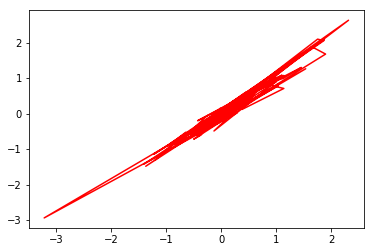

In [4]:
x = samples.extract('x')['x']
plt.plot(x[:,0], x[:,1], 'r-');

Bayesian linear regression: 

In [5]:
lm_code = """
    data {
        int<lower=1> N; // Number of samples
        int<lower=1> D; // Number of features
        matrix[N,D] X; // Design matrix
        vector[N] t; // target values
    }
    parameters {
        vector[D] w; // weight vector
        real<lower=0> sigma; // Observation noise
    }
    model {
        vector[N] y;
        
        w ~ normal(0, 100); // Prior p(w)
        y <- X*w;
        t ~ normal(y, sigma);
    }
    generated quantities {
        real<lower=0> mse; // Training error
        real R2; // Explained variance
        vector[N] y;
        
        y <- X*w;
        mse <- 1.0/N*dot_self(y-t);
        R2 <- 1.0 - mse/variance(t);
    }
"""

stan_lm = pystan.StanModel(model_code=lm_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_49654f16f77396a28ea7688d8535031e NOW.


/home/mo/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


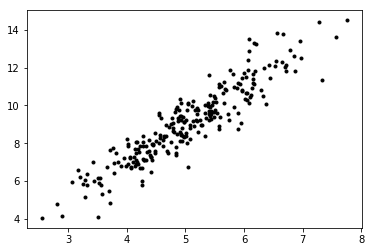

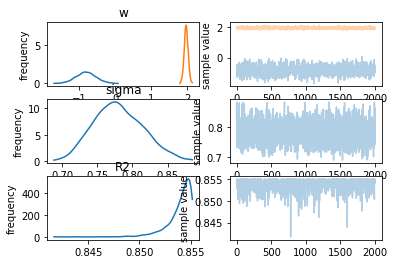

In [6]:
N = 250
x = np.hstack([np.ones((N,1)), 5+np.random.normal(size=(N,1))])
t = np.dot(x, np.array([-1,2])) + np.random.normal(size=(N,), scale=0.8)
plt.plot(x[:,1], t, 'k.')

fit = stan_lm.sampling(data={'N': N, 'D': x.shape[1], 'X': x, 't': t}, \
                       iter=1000, chains=4)
fit.plot(['w','sigma', 'R2']);

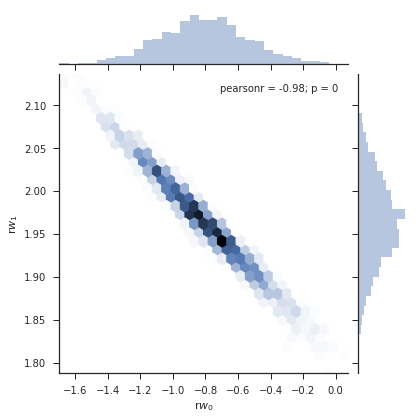

In [7]:
import seaborn as sns; sns.set() # set default plot styles
import pandas as pd

df_2D = pd.DataFrame(fit.extract('w')['w'], columns=['r$w_0$', 'r$w_1$'])

xlim, ylim = zip(df_2D.min(0), df_2D.max(0))
with sns.axes_style('ticks'):
    jointplot = sns.jointplot('r$w_0$', 'r$w_1$',
                              xlim=xlim, ylim=ylim,
                              data=df_2D, kind="hex");

Both, Gibbs sampling and HMC utilize informed proposal distributions to achieve efficient sampling. Yet, we have seen that Gibbs sampling mixes slowly when there are strong dependencies in the posterior. HMC can fail to explore the posterior in this case as well, albeit for a very different reason. Here the numerical integration of the Hamiltonian dynamics can lead to divergent trajectories if the local curvature of the posterior is large. Luckily, we can often diagnose this problem as Stan informs us about divergent trajectories.

The following table compares Gibbs sampling and HMC
<table>
<tr>
<th></th>
<th>Gibbs sampling</th>
<th>HMC</th>
</tr>
<tr>
<td>Informed proposal</td>
<td>Conditional distribution</td>
<td>Gradient of log density</td>
</tr>
<tr>
<td>Discrete distributions</td>
<td>Yes</td>
<td>No</td>
</tr>
<tr>
<td>Continuous densities</td>
<td>Requires conjugacy</td>
<td>Yes</td>
</tr>
<tr>
<td>Invariance</td>
<td>Scaling</td>
<td>Rotation</td>
</tr>
<tr>
<td>Sampling problems</td>
<td>High dependencies</td>
<td>Curved geometry</td>
</tr>
</table>

Next, we investigate Neal's funnel, a standard example which poses problems for HMC:

In [8]:
def neal_funnel (x, y):
    return np.exp(norm(0, 3).logpdf(y) + np.sum(norm(0, np.exp(y/2.)).logpdf(x)))

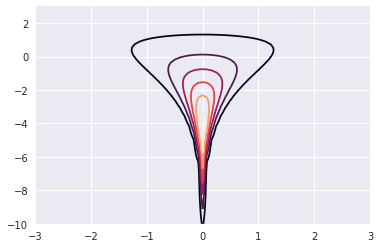

In [9]:
X, Y = np.meshgrid(np.linspace(-3,3,75), np.linspace(-10,3,75))
plt.contour(X, Y, np.vectorize(lambda x, y: neal_funnel(x, y))(X, Y))

This distribution has a very thin (low volume) "funnel" which nevertheless holds about half of the probability density. A good sampler now needs to explore a large volume of low density as well as moving into the thin funnel.

* Will the Gibbs sampler be able to explore Neal's funnel?
* Note: Neither globally rescaling or rotating the distribution will reduce this difficulty.

In [10]:
funnel_code = """
data {
  int<lower=0> D;
}
parameters {
  real x[D];
  real y;
}
model {
  y ~ normal(0, 3);
  x ~ normal(0, exp(y/2));
}
"""

stan_funnel = pystan.StanModel(model_code=funnel_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_84e8721acf1131f17dadc4f1c5d7f87c NOW.


35.0 divergent trajectories


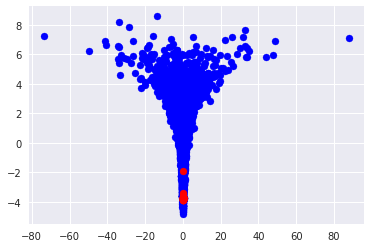

In [11]:
D = 10
funnel = stan_funnel.sampling(data={'D': D})

s = funnel.extract(permuted=False)
d = np.concatenate([x['divergent__'] for x in funnel.get_sampler_params(inc_warmup=False)])
print (np.sum(d), 'divergent trajectories') 
plt.scatter(s[:,:,0].T.flatten()[d==0], s[:,:,D].T.flatten()[d==0], color='b')
plt.scatter(s[:,:,0].T.flatten()[d==1], s[:,:,D].T.flatten()[d==1], color='r');

We see that Stan has difficulties to move into the funnel and there are several divergent trajectories. Also the traceplot does not look quite right as y seems to get stuck occasionally.

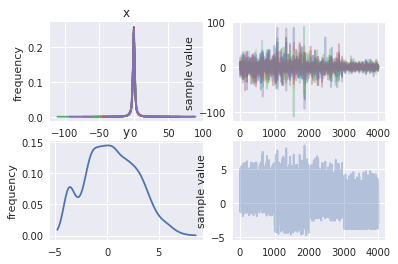

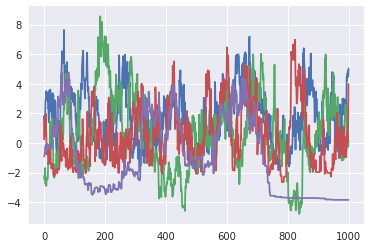

In [12]:
funnel.traceplot()
plt.figure()
plt.plot(funnel.extract(permuted=False)[:,:,D]);

As this is numerical problem of the integration we can try to use a smaller stepsize. This will take more time but the trajectory will be more accurate. The NUTS sampler that Stan uses by default does not allow to set the stepsize directly, but will adjust it during warmup. By increasing the control parameter *adapt_delta* we can nevertheless enforce smaller stepsizes.

As expected the exploration of the sampler improves with adapt_delta=0.99 (default is 0.8). Now there are fewer (no) divergent trajectories and the sampler moves deeper into the funnel. Yet the traceplot for *y* is still problematic ... 

1.0 divergent trajectories


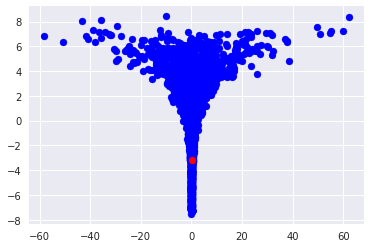

In [13]:
funnel_99 = stan_funnel.sampling(data={'D': D}, control={'adapt_delta': 0.99})

s = funnel_99.extract(permuted=False)
d = np.concatenate([x['divergent__'] for x in funnel_99.get_sampler_params(inc_warmup=False)])
print (np.sum(d), 'divergent trajectories') 
plt.scatter(s[:,:,0].T.flatten()[d==0], s[:,:,D].T.flatten()[d==0], color='b')
plt.scatter(s[:,:,0].T.flatten()[d==1], s[:,:,D].T.flatten()[d==1], color='r');

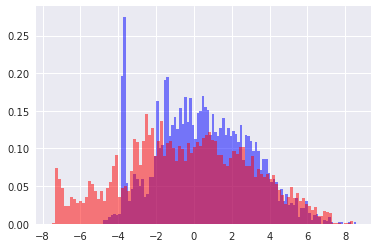

In [14]:
plt.hist(funnel.extract()['y'], alpha=0.5, bins=100, normed=True, color='b')
plt.hist(funnel_99.extract()['y'], alpha=0.5, bins=100, normed=True, color='r');

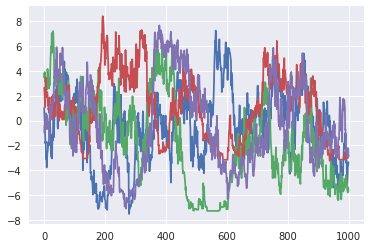

In [15]:
plt.plot(funnel_99.extract(permuted=False)[:,:,D]);

To fix this problem we need to reduce the dependency in the posterior. The so called *non centered* parametrization achives this by introducing a latent variable which has a standard normal prior. The original parameter is now computed from this latent variable which is now truly independent from the log standard deviation $y$ of $x$. 

In [16]:
funnel_code_non_centered = """
data {
  int<lower=1> D;
}
parameters {
  real x_raw[D];
  real y_raw;
}
transformed parameters {
  real x[D];
  real y;

  y <- 3 * y_raw;
  for (d in 1:D)
    x[d] <- exp(y/2) * x_raw[d];
}
model {
  y_raw ~ normal(0, 1);
  x_raw ~ normal(0, 1);
}
"""

stan_funnel_non_centered = pystan.StanModel(model_code=funnel_code_non_centered)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b949dc667924d26651af65f0d80fb837 NOW.


0.0 divergent trajectories


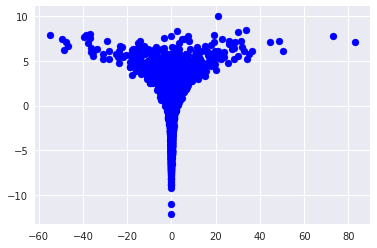

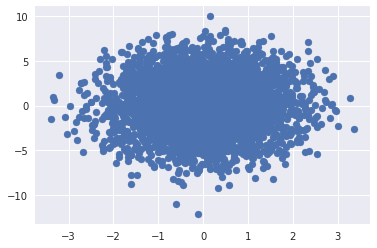

In [17]:
funnel_non_centered = stan_funnel_non_centered.sampling(data={'D': D})

s = funnel_non_centered.extract()
d = np.concatenate([x['divergent__'] for x in funnel_non_centered.get_sampler_params(inc_warmup=False)])
print (np.sum(d), 'divergent trajectories') 
plt.scatter(s['x'][:,0], s['y'], color='b')

plt.figure()
s = funnel_non_centered.extract()
plt.scatter(s['x_raw'][:,0], s['y']);

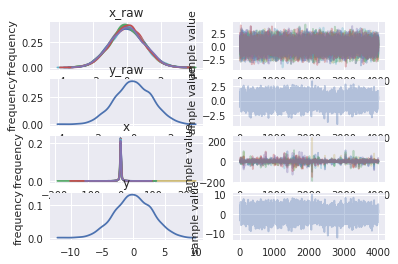

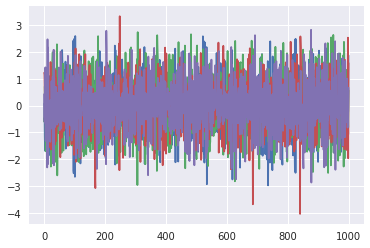

In [18]:
funnel_non_centered.plot()

plt.figure()
plt.plot(funnel_non_centered.extract(permuted=False)[:,:,D]);

In the non centered parametrization the sampler quickly mixes and explores the full funnel. An even better solution -- which does not require to change the model -- is Riemannian HMC which correctly accounts for the geometry (local metric) of the space and can thereby integrate the Hamiltonian without problems.

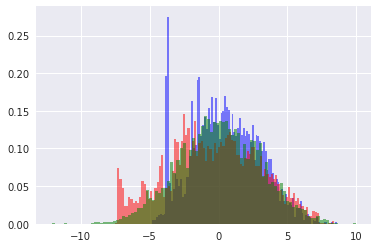

In [19]:
plt.hist(funnel.extract()['y'], alpha=0.5, bins=100, normed=True, color='b')
plt.hist(funnel_99.extract()['y'], alpha=0.5, bins=100, normed=True, color='r')
plt.hist(funnel_non_centered.extract()['y'], alpha=0.5, bins=100, normed=True, color='g');